# 1. Get the data

This code is a didactic reinterpretation of chatper 2 from the book _"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow"_ by Aurélien Géron.

## Download the data

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from utils.data_loader import load_csv

housing_full = load_csv("housing.csv")

✅ Loaded local file: datasets\housing.csv


## Take a quick look at the data structure

In total, there are 10 attributes.

In [4]:
housing_full.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


-When applying the `info()` method, we observe that there are a total of 26,460 instances in the dataset, but the "total_bedrooms" column has only 20,433 non-null values, meaning there are 207 missing entries.

-There are 9 numerical variables and one categorical variable (ocean_proximity).

In [5]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# Missing values
housing_full.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
housing_full['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Below is a summary of the numerical variables.

In [8]:
housing_full.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


A histogram provides a quick overview of the distribution of each numerical attribute, helping to understand how the data is spread and where most values are concentrated.

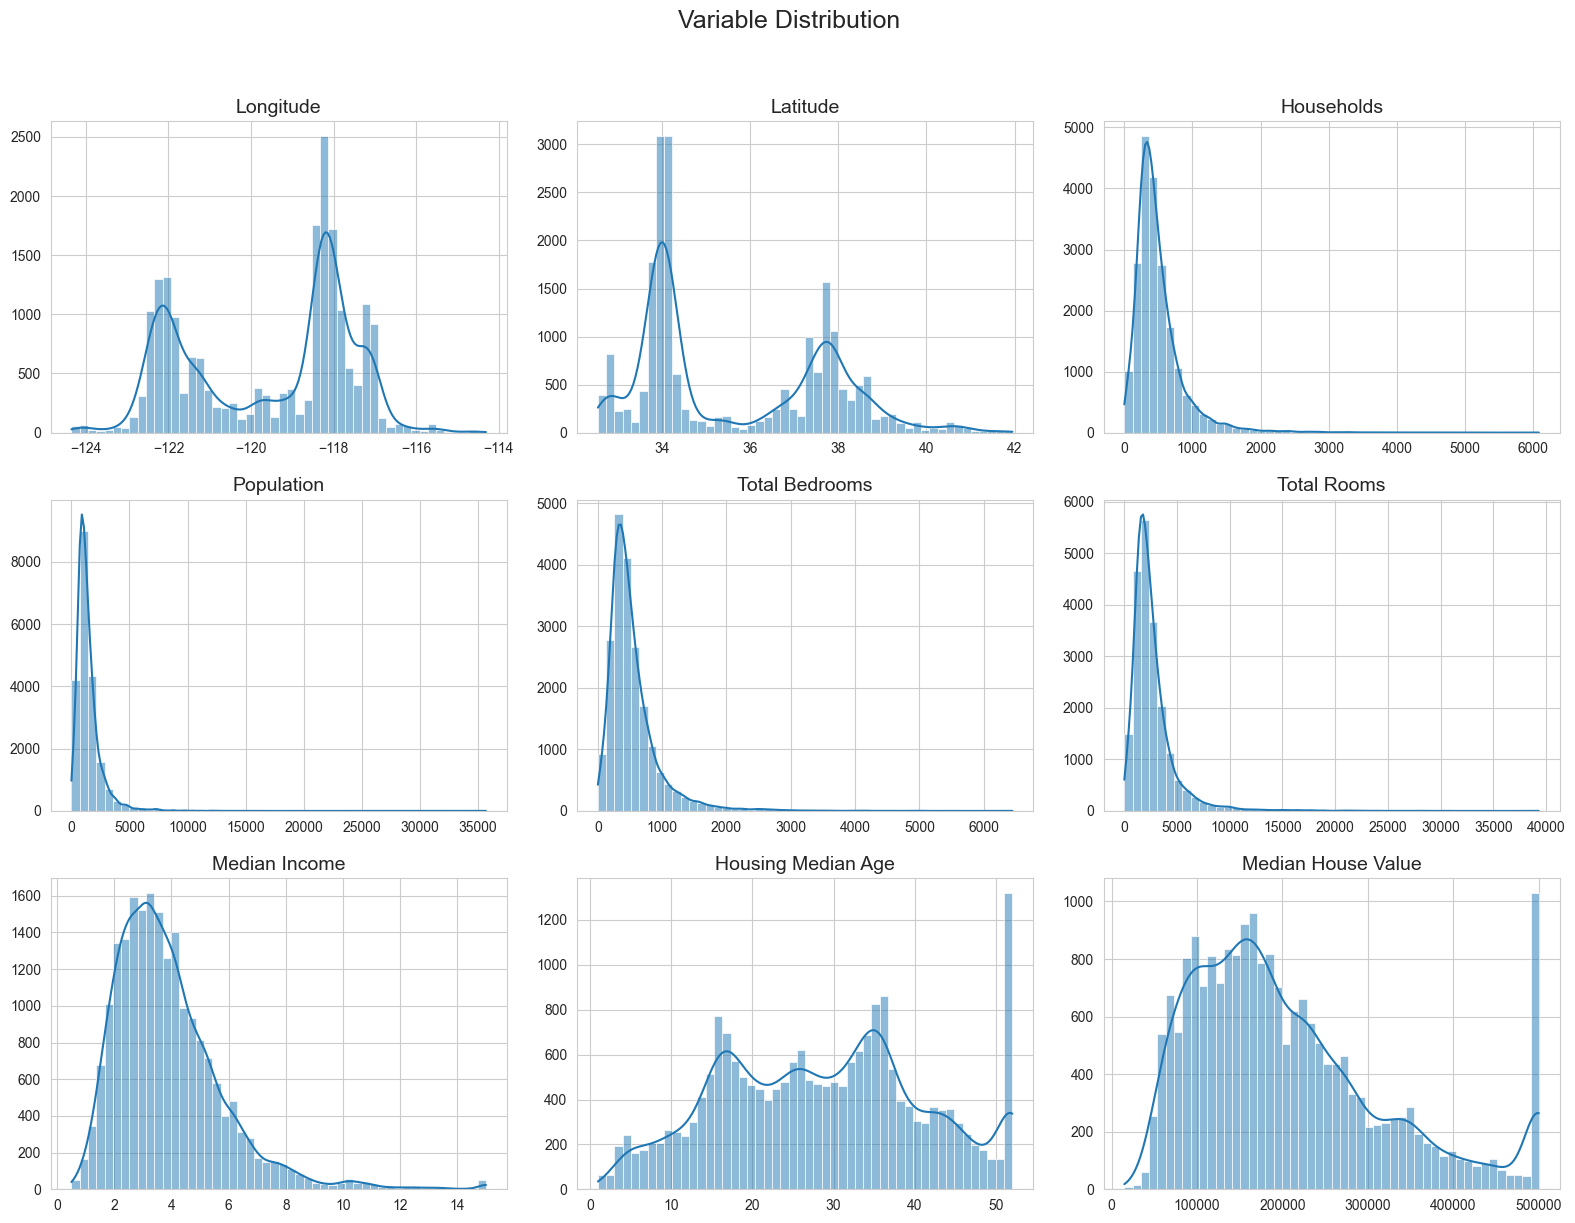

In [ ]:
# Global style
sns.set_style("whitegrid")
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# List of columns to plot
columns = [
    'longitude', 'latitude', 'households',
    'population', 'total_bedrooms', 'total_rooms',
    'median_income', 'housing_median_age', 'median_house_value'
]

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle("Variable Distribution", fontsize=18, y=1.02)

# Create histograms
for col, ax in zip(columns, axes.ravel()):
    data = housing_full[col].dropna()  # por si tiene nulos
    sns.histplot(data, ax=ax, bins=50, kde=True)
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

**Considerations**
- media_income has been scaled and capped at 15 for higher median incomes, and at 0.5 for lower median incomes.
- housing_median_age was algo capped.
- median_house_value was algo capped. This may be a serious problem. The ML algorithm may prices never go beyond that limit.

**Insights**
- Attributes have very different scales.
- Many histograms are skewed right (they extend much farther to the right of the median than to the left).

## Create a test set

**Assumption**
It is assumed that **median income** is an important variable for predicting housing prices. Therefore, it is useful to ensure that the test set is representative of the different income levels in the dataset. Since median income is a continuous numerical variable, it should first be transformed into categorical intervals.

- According to summary statistics, 90% of the data falls below 6.15
- Only 10% of the data goes beyond 6.0, up to a max of ~15
- Creating fewer, well-populated strata (e.g., 5 bins) helps avoid bias in stratified sampling
- The following bins capture the main distribution while keeping higher incomes grouped

In [ ]:
# Basic statistics + percentiles
data = housing_full["median_income"].dropna()
summary = data.describe(percentiles=[.05, .25, .5, .75, .90, .95, .99])
print(summary)

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
5%           1.600570
25%          2.563400
50%          3.534800
75%          4.743250
90%          6.159210
95%          7.300305
99%         10.596540
max         15.000100
Name: median_income, dtype: float64


To ensure the test set is representative of the overall income distribution, we create a new categorical attribute called income_cat. This is done by dividing the median_income variable into five predefined bins:

Bin 1: (0, 1.5] → Very low income

Bin 2: (1.5, 3.0] → Low income

Bin 3: (3.0, 4.5] → Medium income

Bin 4: (4.5, 6.0] → High income

Bin 5: (6.0, ∞) → Very high income

This stratification helps preserve the income distribution when splitting the dataset into training and test sets, avoiding bias that might result from random sampling.

In [11]:
income_bins = [0., 1.5, 3.0, 4.5, 6., np.inf]
income_labels = [1, 2, 3, 4, 5]

housing_full["income_cat"] = pd.cut(
    housing_full["median_income"],
    bins=income_bins,
    labels=income_labels
)

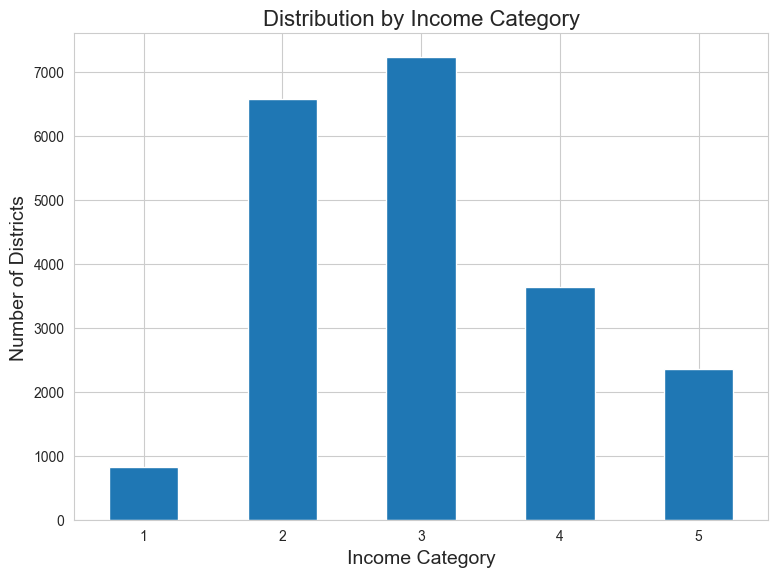

In [12]:
# Bar plot for income_cat
fig, ax = plt.subplots(figsize=(8, 6))

housing_full["income_cat"].value_counts().sort_index().plot.bar(
    ax=ax,
    rot=0,
    grid=True
)

# Aesthetic adjustments
ax.set_title("Distribution by Income Category", fontsize=16)
ax.set_xlabel("Income Category")
ax.set_ylabel("Number of Districts")

plt.tight_layout()
plt.show()

In [ ]:
# Stratified split
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    housing_full, test_size=0.2, stratify=housing_full["income_cat"],
    random_state=42)

In [ ]:
# Create comparison table using predefined bins and labels
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing_full, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({ "Overall %": income_cat_proportions(housing_full),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1)
(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [15]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

# Discover and Visualize Data

In [16]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

Because the dataset includes geographical information (latitude and longitude), it is a good idea to create a scatterplot of all the districts to visualize the data.

The following scatter plot displays the geographical distribution of housing in California. High-density areas are clearly visible, as well as variations in median house values based on location.

<Axes: xlabel='longitude', ylabel='latitude'>

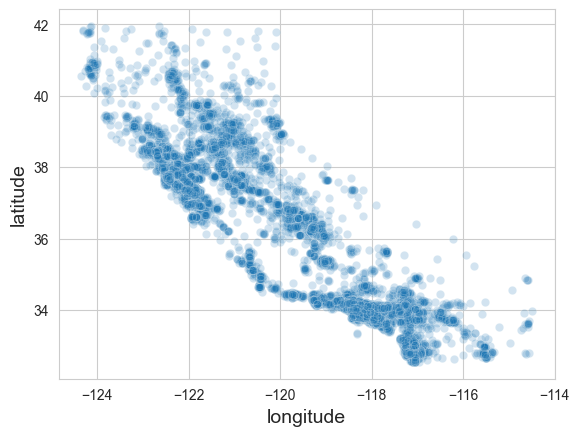

In [17]:
sns.scatterplot(x='longitude', y='latitude', data=housing, alpha=0.2)

The scatter plot uses circle size to represent district population and color to indicate median house value, applying the 'turbo' colormap to highlight price variations from low (blue) to high (red).

The image indicates a strong relationship between housing prices, location, and population density. Although ocean proximity can be a relevant factor, its influence is not consistent across all regions.

<Figure size 1200x800 with 0 Axes>

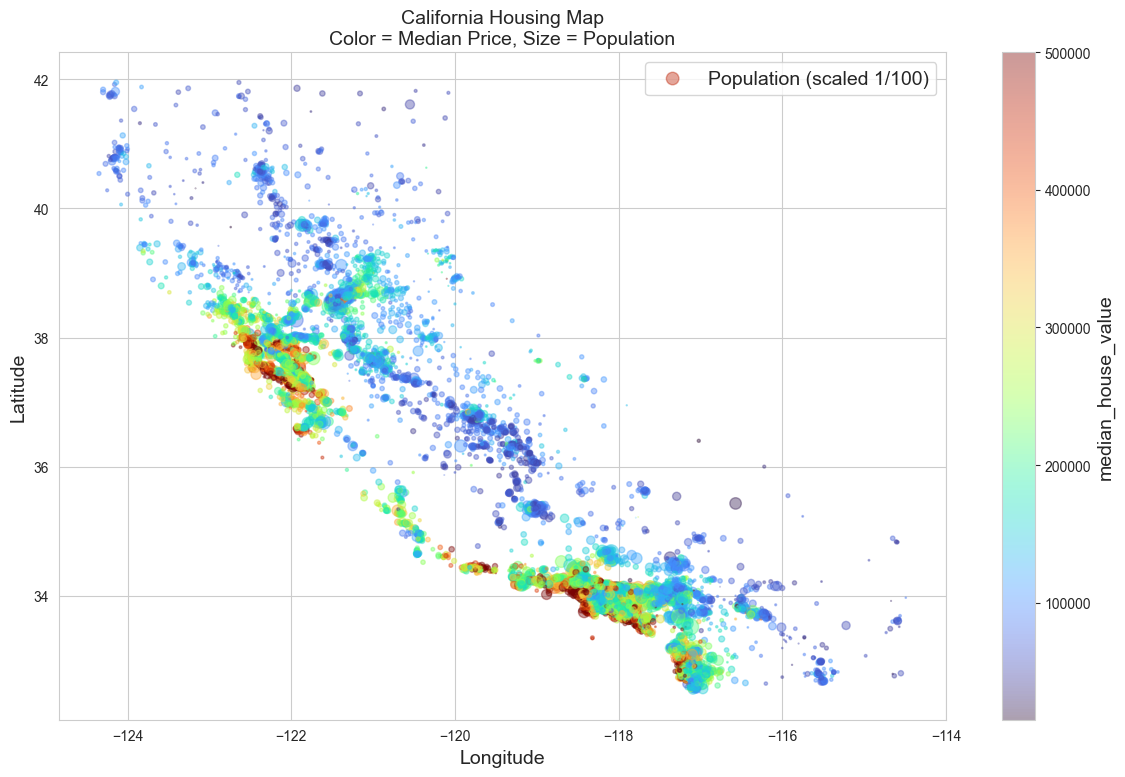

In [18]:
import matplotlib.pyplot as plt

cmap = plt.colormaps['turbo']  # Modern alternative to plt.cm.get_cmap()

plt.figure(figsize=(12, 8))
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=housing['population'] / 100,
    label='Population (scaled 1/100)',
    c='median_house_value',
    cmap=cmap,
    colorbar=True,
    figsize=(12, 8)
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("California Housing Map\nColor = Median Price, Size = Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Looking for Correlations

In [19]:
corr_matrix = housing.corr(numeric_only=True)

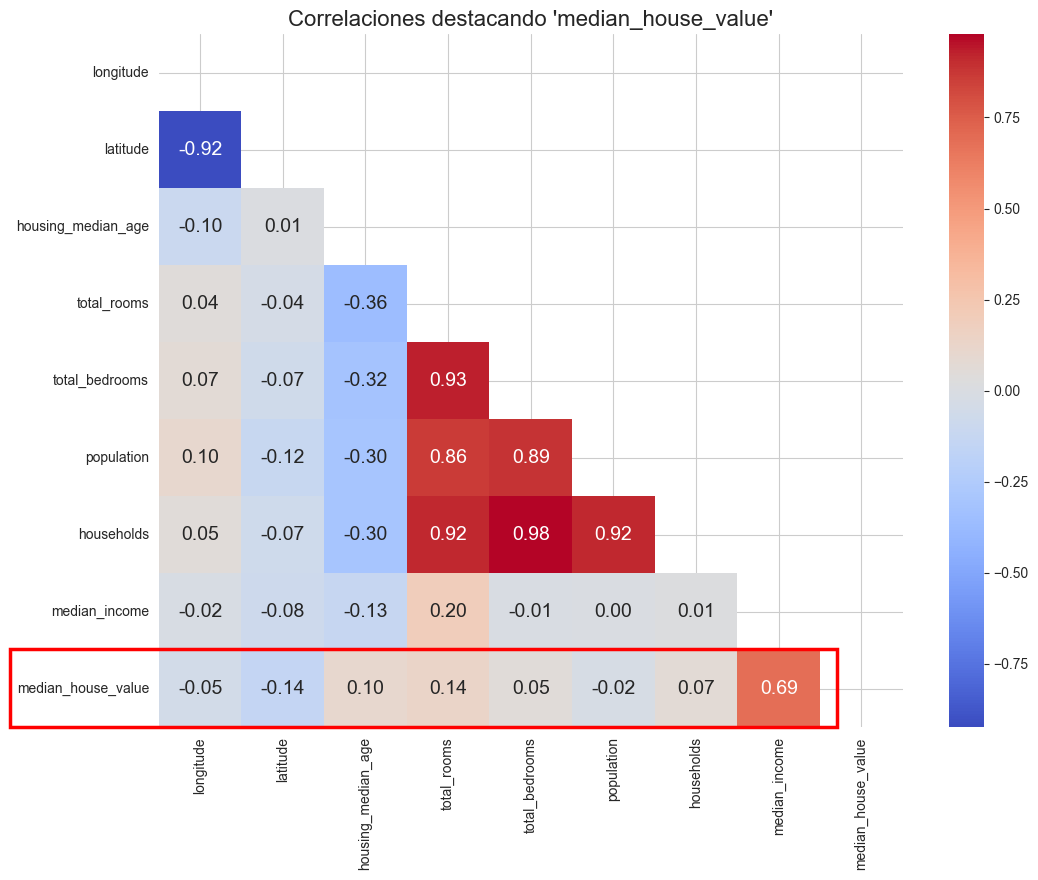

In [ ]:
import matplotlib.patches as patches

plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")

# ==== Coordenadas corregidas tras calibrar spacing ====
target_row = corr_matrix.index.get_loc("median_house_value")
n_cols = len(corr_matrix.columns)

rect = patches.Rectangle(
    xy=(-1.8, target_row - 0.02),   # x, y coordinates
    width=n_cols + 1.0,            # width: number of columns + space for row labels
    height=1.02,                   # height: exactly one row
    linewidth=2.5,
    edgecolor='red',
    facecolor='none',
    clip_on=False                  # IMPORTANT: allows drawing outside the visible area
)
ax.add_patch(rect)

plt.title("Correlaciones destacando 'median_house_value'", fontsize=16)
plt.show()


Based on the correlation scatterplots, the median income appears to be the most promising attribute to predict the median house value, which justifies focusing on its scatterplot.

The plot reveals several insights. There is a strong positive correlation, as indicated by the clear upward trend and relatively low dispersion of data points. A distinct price ceiling is visible around $500,000, forming a horizontal line. Additional, less prominent horizontal patterns appear near $450,000, $350,000, approximately $280,000, and at several lower levels, suggesting other artificial limits or rounding effects.

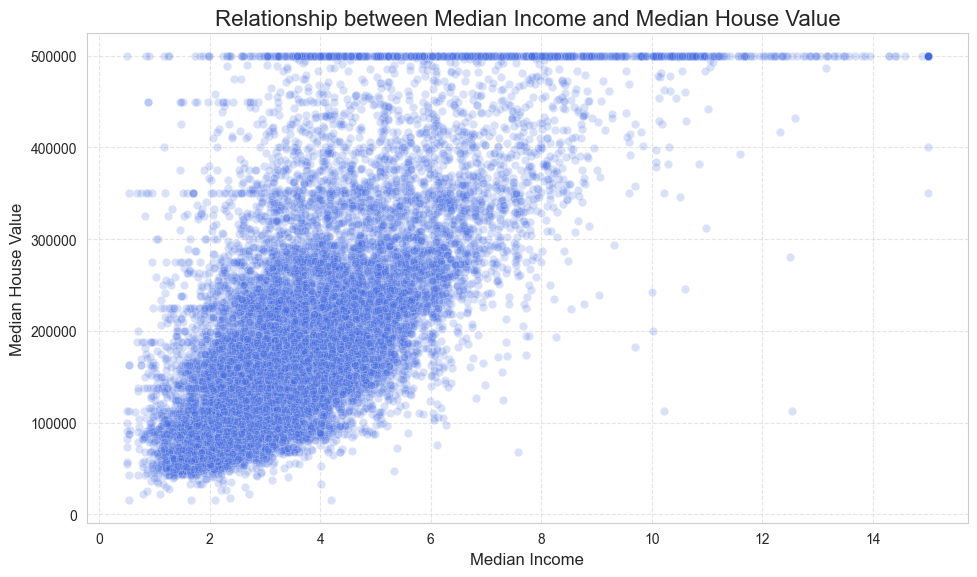

In [43]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=housing,
    x="median_income",
    y="median_house_value",
    alpha=0.2,
    color="royalblue"
)

plt.title("Relationship between Median Income and Median House Value", fontsize=16)
plt.xlabel("Median Income", fontsize=12)
plt.ylabel("Median House Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Experimenting with Attribute Combinations

The total number of rooms in a district provides limited insight without considering the number of households. A more meaningful metric is the number of rooms per household. Similarly, the total number of bedrooms is more informative when compared to the total number of rooms. Population per household also emerges as a potentially useful attribute combination for analysis.

In [44]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

 The new bedrooms_ratio attribute is much more correlated with the median house value than the total number of rooms or bedrooms. It’s a strong negative correlation, so it looks like houses with a lower bedroom/room ratio tend to be more expensive.

In [48]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`)

In [49]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning

In this case, missing values are replaced using the mean of each numerical attribute, a common and simple imputation strategy that helps preserve the overall distribution of the data.

In [50]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):

In [51]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable.

In [52]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Check that this is the same as manually computing the median of each attribute:

In [53]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Although only the `"total_bedroom"` attribute contains missing values in the current dataset, there is no guarantee that future data will be complete once the system is deployed. Therefore, applying the imputer to all numerical attributes is a safer approach.

Transform the training set:

In [54]:
X = imputer.transform(housing_num)

Scikit-Learn transformers typically return NumPy arrays (or occasionally SciPy sparse matrices), even when provided with Pandas DataFrames as input. As a result, `imputer.transform(housing_num)` produces a NumPy array without column names or index. To maintain consistency and interpretability, the output array can be wrapped in a new DataFrame, restoring both the original column names and index from `housing_num`.

In [56]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

Besides simple strategies like mean imputation, Scikit-learn provides more powerful options for numerical features:

- `KNNImputer`
Replaces missing values using the average of the k nearest neighbors for each feature, based on distance across available features.

- `IterativeImputer`
Predicts missing values by training a regression model per feature using the other features as predictors. The process is repeated iteratively to refine the estimates.

## Handling Text and Categorical Attributes